# Sick House Bro
## Authors: Frank Vasquez (fav3ba), June Suh (kqj8be), Kevin Lin (pex7ps)
### Goal: Determine if the pandemic had a direct impact on the housing market, and see if trends are discoverable


### TODO:

First covid cases in US were confirmed in January 2020

Number of records: 38,475 \
Number of columns: 2 predictors, 1 response, 1 col to group by county, 1 col to group by date\

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.functions import concat, col, lit

spark = SparkSession.builder.getOrCreate()
data_dir = '../data/' 

# Read in data

## 1. FIPS to county crosswalk

In [2]:
# fips to county read in and add columns to be compatible with other data

schema = StructType([StructField("state", StringType(), False),
                     StructField("state_fips", StringType(), False),
                     StructField("county_fips", StringType(), False),
                     StructField("county_name", StringType(), False),
                     StructField("H", StringType(), False)])

fips2county = spark.read.csv(f"{data_dir}/fips2county.txt",  schema)
fips2county = fips2county.withColumn('full_fips', concat(fips2county.state_fips,fips2county.county_fips)) \
                .withColumn('full_county', concat(fips2county.county_name, lit(', '), fips2county.state))

In [3]:
fips2county.show(5)

+-----+----------+-----------+--------------+---+---------+------------------+
|state|state_fips|county_fips|   county_name|  H|full_fips|       full_county|
+-----+----------+-----------+--------------+---+---------+------------------+
|   AL|        01|        001|Autauga County| H1|    01001|Autauga County, AL|
|   AL|        01|        003|Baldwin County| H1|    01003|Baldwin County, AL|
|   AL|        01|        005|Barbour County| H1|    01005|Barbour County, AL|
|   AL|        01|        007|   Bibb County| H1|    01007|   Bibb County, AL|
|   AL|        01|        009| Blount County| H1|    01009| Blount County, AL|
+-----+----------+-----------+--------------+---+---------+------------------+
only showing top 5 rows



## 2. Median house prices

In [4]:
# infer schema does not work here, too many columns to manually type
# using pandas to cut down dataframe to useful part, manual schema to convert to spark data frame

house = pd.read_csv(f"{data_dir}/med_sale_price_counties.csv", header=1) # import with pandas to skip first row
house.shape # 1860 counties, 120 months, only want last 24 (2020-2021)
house_county = pd.DataFrame(house.iloc[:,0]) # grab first column
house_pand = house.iloc[:, -24:] # grab 2020 and 2021
new_house = house_county.join(house_pand) # append first column to subset of data

In [5]:
# create schema from list of columns to get around improper schema inference
schema_list = []
for i in new_house.columns:
    schema_list.append(StructField(i, StringType(), False))
schema = StructType(schema_list)

In [6]:
# create spark data frame using schema built from column names
house = spark.createDataFrame(new_house, schema=schema)

In [7]:
house.show(5)

+--------------------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+
|              Region|Jan-20|Feb-20|Mar-20|Apr-20|May-20|Jun-20|Jul-20|Aug-20|Sep-20|Oct-20|Nov-20|Dec-20|Jan-21|Feb-21|Mar-21|Apr-21|May-21|Jun-21|Jul-21|Aug-21|Sep-21|Oct-21|Nov-21|Dec-21|
+--------------------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+
|Abbeville County, SC| $200K| $229K| $216K| $103K| $159K| $168K| $183K| $193K| $160K| $175K| $143K| $158K| $215K| $222K| $125K| $225K| $173K| $280K| $352K| $271K| $111K| $169K| $220K| $159K|
|      Ada County, ID| $360K| $360K| $365K| $366K| $360K| $372K| $385K| $400K| $404K| $401K| $420K| $425K| $440K| $452K| $463K| $480K| $510K| $517K| $538K| $525K| $525K| $526K| $530K| $539K|
|    Adair County, IA|  $62K| $127K|  $60K| $

## 3. COVID case and death data

In [8]:
# read in covid positive and death data

case_data =  spark.read.csv(f"{data_dir}/time_series_covid19_confirmed_US.csv", inferSchema=True, header=True)
death_data = spark.read.csv(f"{data_dir}/time_series_covid19_deaths_US.csv", inferSchema=True, header=True)

In [9]:
# convert fips codes to strings
case_data = case_data.withColumn("UID",case_data["UID"].cast('string'))
death_data = death_data.withColumn("UID",death_data["UID"].cast('string'))

# create 5 digit fips columns
case_data = case_data.withColumn('FIPS', case_data['UID'][4:8])
death_data = death_data.withColumn('FIPS', death_data['UID'][4:8])

In [10]:
# create month labels for aggregation of cases and deaths
# format chosen to match house data
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct","Nov","Dec"]
years = ['20','21'] #,'2022'] add back in if wanting 2022 data
combined = []
for x in months:
    for y in years:
        combined.append(x+"-"+y) # using same naming scheme as housing data

# add columns for aggregation
# there's probably a way to do this all at once instead of as a loop
for date in combined:
    case_data = case_data.withColumn(date, lit(0))
    death_data = death_data.withColumn(date, lit(0))

In [11]:
# aggregate to month columns
# there's gotta be a better way to do this but I can't think of it
# convert to pandas dataframe for aggregation step, faster due to communication time

death_schema = death_data.schema
case_schema = case_data.schema

death_data = death_data.toPandas()
case_data = case_data.toPandas()

# death data
for i in range(0, len(death_data.columns)):
    col_name = death_data.columns[i]
    temp = col_name.split('/')
    if(len(temp) == 3): # makes sure to only work on date columns
        temp = [int(i) for i in temp] 
        if(temp[2] == 20):
            if(temp[0] == 1): death_data['Jan-20'] = death_data['Jan-20']+death_data[col_name]
            if(temp[0] == 2): death_data['Feb-20'] = death_data['Feb-20']+death_data[col_name]
            if(temp[0] == 3): death_data['Mar-20'] = death_data['Mar-20']+death_data[col_name]
            if(temp[0] == 4): death_data['Apr-20'] = death_data['Apr-20']+death_data[col_name]
            if(temp[0] == 5): death_data['May-20'] = death_data['May-20']+death_data[col_name]
            if(temp[0] == 6): death_data['Jun-20'] = death_data['Jun-20']+death_data[col_name]
            if(temp[0] == 7): death_data['Jul-20'] = death_data['Jul-20']+death_data[col_name]
            if(temp[0] == 8): death_data['Aug-20'] = death_data['Aug-20']+death_data[col_name]
            if(temp[0] == 9): death_data['Sep-20'] = death_data['Sep-20']+death_data[col_name]
            if(temp[0] == 10): death_data['Oct-20'] = death_data['Oct-20']+death_data[col_name]
            if(temp[0] == 11): death_data['Nov-20'] = death_data['Nov-20']+death_data[col_name]
            if(temp[0] == 12): death_data['Dec-20'] = death_data['Dec-20']+death_data[col_name]
        if(temp[2] == 21):
            if(temp[0] == 1): death_data['Jan-21'] = death_data['Jan-21']+death_data[col_name]
            if(temp[0] == 2): death_data['Feb-21'] = death_data['Feb-21']+death_data[col_name]
            if(temp[0] == 3): death_data['Mar-21'] = death_data['Mar-21']+death_data[col_name]
            if(temp[0] == 4): death_data['Apr-21'] = death_data['Apr-21']+death_data[col_name]
            if(temp[0] == 5): death_data['May-21'] = death_data['May-21']+death_data[col_name]
            if(temp[0] == 6): death_data['Jun-21'] = death_data['Jun-21']+death_data[col_name]
            if(temp[0] == 7): death_data['Jul-21'] = death_data['Jul-21']+death_data[col_name]
            if(temp[0] == 8): death_data['Aug-21'] = death_data['Aug-21']+death_data[col_name]
            if(temp[0] == 9): death_data['Sep-21'] = death_data['Sep-21']+death_data[col_name]
            if(temp[0] == 10): death_data['Oct-21'] = death_data['Oct-21']+death_data[col_name]
            if(temp[0] == 11): death_data['Nov-21'] = death_data['Nov-21']+death_data[col_name]
            if(temp[0] == 12): death_data['Dec-21'] = death_data['Dec-21']+death_data[col_name] # don't have data after this for houses
        #if(temp[2] == 22):
         #   if(temp[0] == 1): death_data['Jan-2022'] = death_data['Jan-2022']+death_data[col_name]
          #  if(temp[0] == 2): death_data['Feb-2022'] = death_data['Feb-2022']+death_data[col_name] # data after this won't exist
                
# case data
for i in range(0, len(case_data.columns)):
    col_name = case_data.columns[i]
    temp = col_name.split('/')
    if(len(temp) == 3): # makes sure to only work on date columns
        temp = [int(i) for i in temp] 
        if(temp[2] == 20):
            if(temp[0] == 1): case_data['Jan-20'] = case_data['Jan-20']+case_data[col_name]
            if(temp[0] == 2): case_data['Feb-20'] = case_data['Feb-20']+case_data[col_name]
            if(temp[0] == 3): case_data['Mar-20'] = case_data['Mar-20']+case_data[col_name]
            if(temp[0] == 4): case_data['Apr-20'] = case_data['Apr-20']+case_data[col_name]
            if(temp[0] == 5): case_data['May-20'] = case_data['May-20']+case_data[col_name]
            if(temp[0] == 6): case_data['Jun-20'] = case_data['Jun-20']+case_data[col_name]
            if(temp[0] == 7): case_data['Jul-20'] = case_data['Jul-20']+case_data[col_name]
            if(temp[0] == 8): case_data['Aug-20'] = case_data['Aug-20']+case_data[col_name]
            if(temp[0] == 9): case_data['Sep-20'] = case_data['Sep-20']+case_data[col_name]
            if(temp[0] == 10): case_data['Oct-20'] = case_data['Oct-20']+case_data[col_name]
            if(temp[0] == 11): case_data['Nov-20'] = case_data['Nov-20']+case_data[col_name]
            if(temp[0] == 12): case_data['Dec-20'] = case_data['Dec-20']+case_data[col_name]
        if(temp[2] == 21):
            if(temp[0] == 1): case_data['Jan-21'] = case_data['Jan-21']+case_data[col_name]
            if(temp[0] == 2): case_data['Feb-21'] = case_data['Feb-21']+case_data[col_name]
            if(temp[0] == 3): case_data['Mar-21'] = case_data['Mar-21']+case_data[col_name]
            if(temp[0] == 4): case_data['Apr-21'] = case_data['Apr-21']+case_data[col_name]
            if(temp[0] == 5): case_data['May-21'] = case_data['May-21']+case_data[col_name]
            if(temp[0] == 6): case_data['Jun-21'] = case_data['Jun-21']+case_data[col_name]
            if(temp[0] == 7): case_data['Jul-21'] = case_data['Jul-21']+case_data[col_name]
            if(temp[0] == 8): case_data['Aug-21'] = case_data['Aug-21']+case_data[col_name]
            if(temp[0] == 9): case_data['Sep-21'] = case_data['Sep-21']+case_data[col_name]
            if(temp[0] == 10): case_data['Oct-21'] = case_data['Oct-21']+case_data[col_name]
            if(temp[0] == 11): case_data['Nov-21'] = case_data['Nov-21']+case_data[col_name]
            if(temp[0] == 12): case_data['Dec-21'] = case_data['Dec-21']+case_data[col_name] # don't have data after this for houses
     #   if(temp[2] == 22):
      #      if(temp[0] == 1): case_data['Jan-2022'] = case_data['Jan-2022']+case_data[col_name]
       #     if(temp[0] == 2): case_data['Feb-2022'] = case_data['Feb-2022']+case_data[col_name] # data after this won't exist
    
    
# return to spark dataframes
death_data = spark.createDataFrame(death_data, schema=death_schema)
case_data = spark.createDataFrame(case_data, schema=case_schema)

In [12]:
# take only relevant columns
combined.append('FIPS') # for making new DFs with only relevant columns
death_data_clean = death_data.select(*combined)
case_data_clean = case_data.select(*combined)

# Combine Data

Need to do some creative pandas manipulation to create features from data
Unstack is a pandas specific operation, and Spark DFs do not use indices

In [13]:
# add fips to house data frame
fips2county = fips2county.withColumnRenamed("full_county","Region")
house = house.join(fips2county,['Region'],how='outer')
house = house.withColumnRenamed('full_fips','FIPS')

In [14]:
#convert to pandas
house = house.toPandas()

# drop unnecessary columns and index by FIPS and date
house.index = house.FIPS
house = house.drop(['Region','state','state_fips','county_fips','county_name','H','FIPS'], axis=1) # drops extra columns
house_date_fips = pd.DataFrame(house.unstack(), columns=['median_home_value']) # indexes by date and FIPS
house_date_fips = house_date_fips.dropna()

In [15]:
# convert to pandas
case_data_clean = case_data_clean.toPandas()
death_data_clean = death_data_clean.toPandas()

# change index to FIPS and drop FIPS column
case_data_clean.index = case_data_clean.FIPS
case_data_clean = case_data_clean.drop('FIPS', axis=1)
death_data_clean.index = death_data_clean.FIPS
death_data_clean = death_data_clean.drop('FIPS', axis=1)

# index death and case data by date
case_date_fips = pd.DataFrame(case_data_clean.unstack(), columns=['confirmed_cases'])
death_date_fips = pd.DataFrame(death_data_clean.unstack(), columns=['confirmed_deaths'])
case_date_fips = case_date_fips.dropna()
death_date_fips = death_date_fips.dropna()

In [16]:
case_date_fips

confirmed_cases
       FIPS                  
Jan-20 01001                0
       01003                0
       01005                0
       01007                0
       01009                0
...                       ...
Dec-21 56039           171435
       56041           127294
       90056                0
       56043            57729
       56045            38058

[80208 rows x 1 columns]

In [17]:
# create column to join on for all dfs from indices

death_date_fips['date_fips'] = ""
for i in range(0,len(death_date_fips)):
    death_date_fips['date_fips'][i] = death_date_fips.index[i][0]+'-'+death_date_fips.index[i][1]

print("Death done")
    
case_date_fips['date_fips'] = ""
for i in range(0,len(case_date_fips)):
    case_date_fips['date_fips'][i] = case_date_fips.index[i][0]+'-'+case_date_fips.index[i][1]
    
print("Cases done")
    
house_date_fips['date_fips'] = ""
for i in range(0,len(house_date_fips)):
    house_date_fips['date_fips'][i] = str(house_date_fips.index[i][0])+'-'+str(house_date_fips.index[i][1])
                                          
print("Houses done")

/opt/conda/lib/python3.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Death done


/opt/conda/lib/python3.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Cases done
Houses done


In [18]:
# convert back to Spark
house_schema = StructType([StructField("median_home_value", StringType(), False),
                           StructField("date_fips", StringType(), False)])
death_schema = StructType([StructField("confirmed_deaths", IntegerType(), False),
                           StructField("date_fips", StringType(), False)])
case_schema = StructType([StructField("confirmed_cases", IntegerType(), False),
                          StructField("date_fips", StringType(), False)])

house = spark.createDataFrame(house_date_fips, schema=house_schema)
death_data = spark.createDataFrame(death_date_fips, schema=death_schema)
case_data = spark.createDataFrame(case_date_fips, schema=case_schema)

In [19]:
# merge dfs and drop NA

combined_df = house.join(death_data,['date_fips'],how='outer')
combined_df = combined_df.join(case_data,['date_fips'],how='outer')
combined_df = combined_df.dropna()
combined_df = combined_df.filter(combined_df.median_home_value != 'NaN') # some NaN values converted to strings
combined_df.take(5)

[Row(date_fips='Apr-20-17083', median_home_value='$175K', confirmed_deaths=6, confirmed_cases=214),
 Row(date_fips='Apr-20-39029', median_home_value='$85K', confirmed_deaths=452, confirmed_cases=4061),
 Row(date_fips='Apr-20-41059', median_home_value='$230K', confirmed_deaths=0, confirmed_cases=630),
 Row(date_fips='Apr-20-42063', median_home_value='$145K', confirmed_deaths=58, confirmed_cases=1185),
 Row(date_fips='Apr-20-47139', median_home_value='$260K', confirmed_deaths=0, confirmed_cases=142)]

In [20]:
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql import Window

# convert home value to dollars

med_val = combined_df.select('median_home_value').rdd.flatMap(lambda x: x).collect() # convert to list
med_val = [x[1:-1] for x in med_val]
med_val = [int(x.replace(',', '')) for x in med_val] # convert to int and handle commas
med_val = [x*1000 for x in med_val]
med_val_df = spark.createDataFrame([(l,) for l in med_val], ['median_home_value'])

# make new median_home_value columns (might be a shorter way to do this)
combined_df = combined_df.drop('median_home_value')
combined_df = combined_df.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
med_val_df = med_val_df.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
combined_df = combined_df.join(med_val_df, combined_df.row_idx == med_val_df.row_idx).drop("row_idx")

combined_df.take(5)

[Row(date_fips='Apr-20-17083', confirmed_deaths=6, confirmed_cases=214, median_home_value=175000),
 Row(date_fips='Apr-20-39029', confirmed_deaths=452, confirmed_cases=4061, median_home_value=85000),
 Row(date_fips='Apr-20-41059', confirmed_deaths=0, confirmed_cases=630, median_home_value=230000),
 Row(date_fips='Apr-20-42063', confirmed_deaths=58, confirmed_cases=1185, median_home_value=145000),
 Row(date_fips='Apr-20-47139', confirmed_deaths=0, confirmed_cases=142, median_home_value=260000)]

In [21]:
# pull out fips code and date separately
dateFips = combined_df.select('date_fips').rdd.flatMap(lambda x: x).collect()
fips = [x[-5:] for x in dateFips]
date = [x[:6] for x in dateFips]

fips_df = spark.createDataFrame([(l,) for l in fips], ['fips'])
date_df = spark.createDataFrame([(l,) for l in date], ['date'])

combined_df = combined_df.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
fips_df = fips_df.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
combined_df = combined_df.join(fips_df, combined_df.row_idx == fips_df.row_idx).drop('row_idx')
combined_df = combined_df.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
date_df = date_df.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
combined_df = combined_df.join(date_df, combined_df.row_idx == date_df.row_idx).drop('row_idx')

combined_df.take(5)

[Row(date_fips='Apr-20-17083', confirmed_deaths=6, confirmed_cases=214, median_home_value=175000, fips='17083', date='Apr-20'),
 Row(date_fips='Apr-20-39029', confirmed_deaths=452, confirmed_cases=4061, median_home_value=85000, fips='39029', date='Apr-20'),
 Row(date_fips='Apr-20-41059', confirmed_deaths=0, confirmed_cases=630, median_home_value=230000, fips='41059', date='Apr-20'),
 Row(date_fips='Apr-20-42063', confirmed_deaths=58, confirmed_cases=1185, median_home_value=145000, fips='42063', date='Apr-20'),
 Row(date_fips='Apr-20-47139', confirmed_deaths=0, confirmed_cases=142, median_home_value=260000, fips='47139', date='Apr-20')]

# Data Exploration

In [22]:
# predictor 1
combined_df.describe(['confirmed_cases']).show()

+-------+------------------+
|summary|   confirmed_cases|
+-------+------------------+
|  count|             38475|
|   mean| 319111.4653411306|
| stddev|1236091.6039068876|
|    min|                 0|
|    max|          48717613|
+-------+------------------+



In [23]:
# predictor 2
combined_df.describe(['confirmed_deaths']).show()

+-------+-----------------+
|summary| confirmed_deaths|
+-------+-----------------+
|  count|            38475|
|   mean| 5733.53380116959|
| stddev|22782.59565112056|
|    min|                0|
|    max|           849402|
+-------+-----------------+



In [24]:
# response
combined_df.describe(['median_home_value']).show()

+-------+------------------+
|summary| median_home_value|
+-------+------------------+
|  count|             38475|
|   mean| 251515.1397011046|
| stddev|186257.69664910855|
|    min|                 0|
|    max|          12250000|
+-------+------------------+



In [25]:
# Order by time for plotting
# required because parallel processing shuffles the items in the dataframe

from pyspark.sql.functions import to_timestamp, sum, mean

df = combined_df.withColumn('date_time', to_timestamp(combined_df.date, 'MMM-yy'))
df.schema
df = df.groupBy('date_time').agg(
                            mean('median_home_value').alias('median_home_value'),
                            sum('confirmed_deaths').alias('confirmed_deaths'),
                            sum('confirmed_cases').alias('confirmed_cases')).sort('date_time')
df_pd = df.toPandas() # for plotting purposes

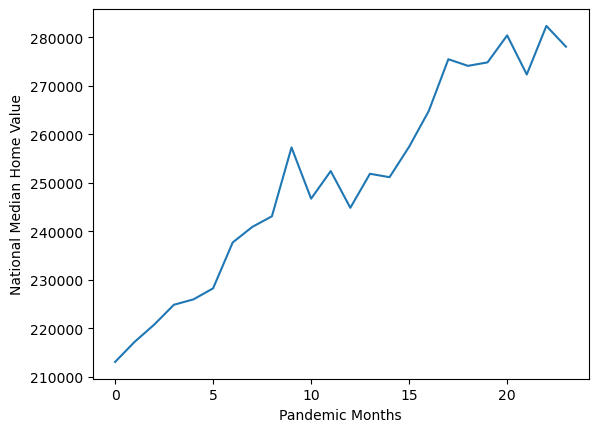

In [26]:
# home values over the pandemic
plt.plot(df_pd.median_home_value)
plt.xlabel('Pandemic Months')
plt.ylabel('National Median Home Value')
plt.show()

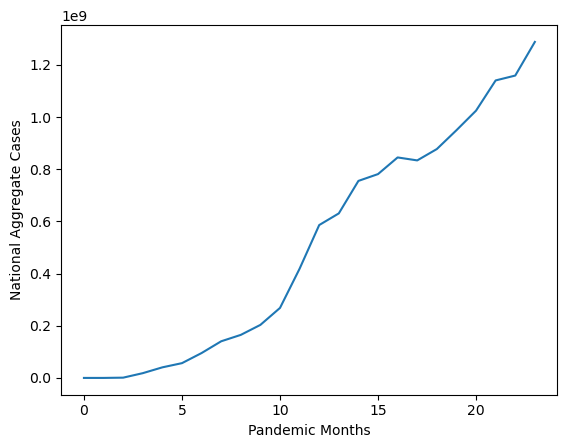

In [27]:
# total cases over the pandemic
plt.plot(df_pd.confirmed_cases)
plt.xlabel('Pandemic Months')
plt.ylabel('National Aggregate Cases')
plt.show()

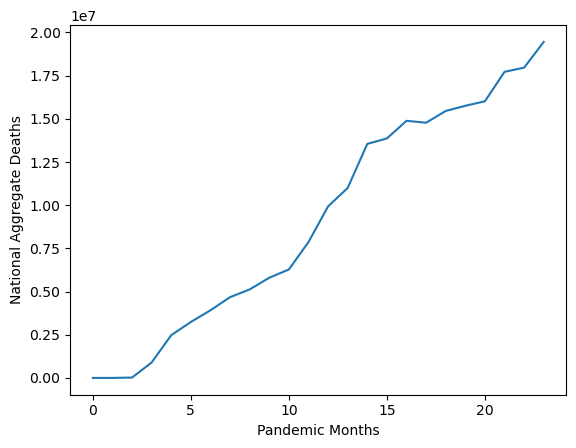

In [28]:
# total deaths over the pandemic
plt.plot(df_pd.confirmed_deaths)
plt.xlabel('Pandemic Months')
plt.ylabel('National Aggregate Deaths')
plt.show()

# Modeling
## Imports

In [29]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

## Setup

In [30]:
feats = ['confirmed_cases','confirmed_deaths']
combined_df = combined_df.withColumn('label', combined_df.median_home_value) # for tree classifiers

assembler = VectorAssembler(inputCols=feats,
                            outputCol="features")

tr = assembler.transform(combined_df)

In [31]:
tr.show(3)

+------------+----------------+---------------+-----------------+-----+------+------+--------------+
|   date_fips|confirmed_deaths|confirmed_cases|median_home_value| fips|  date| label|      features|
+------------+----------------+---------------+-----------------+-----+------+------+--------------+
|Apr-20-17083|               6|            214|           175000|17083|Apr-20|175000|   [214.0,6.0]|
|Apr-20-39029|             452|           4061|            85000|39029|Apr-20| 85000|[4061.0,452.0]|
|Apr-20-41059|               0|            630|           230000|41059|Apr-20|230000|   [630.0,0.0]|
+------------+----------------+---------------+-----------------+-----+------+------+--------------+
only showing top 3 rows



## Train-test split

In [32]:
seed = 69
train_test = [0.8, 0.2]
train_data, test_data = tr.randomSplit(train_test, seed)

## Model Train

### Linear Regression

In [33]:
# I don't have a reason for choosing these parameters other than it's the default from homeworks and lecture. Open to change.

lr = LinearRegression(featuresCol='features',         
                      labelCol='median_home_value',  
                      maxIter=10,
                      regParam=0.3, 
                      elasticNetParam=0.8)

lrModel = lr.fit(train_data)

### Decision Tree Regression

In [34]:
dt = DecisionTreeRegressor(featuresCol='features')

dtModel = dt.fit(train_data)

### Random Forest Regression

In [35]:
rf = RandomForestRegressor(featuresCol='features')

rfModel = rf.fit(train_data)

## Model Test

### Linear Regression

In [36]:
lr_pred = lrModel.transform(test_data)

MSE = []
ev = RegressionEvaluator(predictionCol="prediction", labelCol="median_home_value")
lr_mse = ev.evaluate(lr_pred, {ev.metricName: "mse"})
MSE.append(lr_mse)

### Decision Tree Regression

In [37]:
dt_pred = dtModel.transform(test_data)
dt_mse = ev.evaluate(dt_pred, {ev.metricName: "mse"})
MSE.append(dt_mse)

### Random Forest Regression

In [38]:
rf_pred = rfModel.transform(test_data)
rf_mse = ev.evaluate(rf_pred, {ev.metricName: "mse"})
MSE.append(rf_mse)

## Show results

In [39]:
regression = ['Linear','Decision Tree','Random Forest']
MSE_df = spark.createDataFrame(zip(regression,MSE), ['regression','MSE'])
MSE_df.show()

+-------------+--------------------+
|   regression|                 MSE|
+-------------+--------------------+
|       Linear|3.369250257372688E10|
|Decision Tree|3.217552391379891...|
|Random Forest|  3.1952828739445E10|
+-------------+--------------------+

